# Курс "Программирование на языке Python. Уровень 4. Анализ и визуализация данных на языке Python. Библиотеки numpy, pandas, matplotlib"

## Модуль 10. Анализ данных и алгоритмы машинного обучения

1. Математические библиотеки Python и их применение для анализа/предобработки данных - пример полиномиальной регрессии
1. Кластеризация данных и ее роль в отборе признаков и пре-процессинге
2. Анализ продуктовой корзины
2. Применение scipy/sklearn для отбора признаков
5. Полезные ссылки

__ВНИМАНИЕ__! Установите библиотеки scikit, sklearn и mlxtend: ```pip install scikit sklearn mlxtend```

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy as sp
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (10.0, 10.0)
%matplotlib inline

### Пример применения полиномиальной регрессии для моделирования данных

Допустим, у нас есть ежечасная статистика веб-траффика по некоторому серверу. Нам нужно определить, когда по времени, с учетом текущей динамики, количество запросов превысит 50000/час, чтобы заранее проапгрейдить оборудование. Для этого мы попытаемся построить кривую с помощью полиномиальной регрессии и экстраполируя ее на будущее, определим крайний срок для апгрейда оборудования.

In [2]:
web_traffic = pd.read_csv('data/web_traffic.tsv', sep='\t', header=None, names=['Hour', 'ReqsPerHour'], index_col='Hour')
web_traffic.head()

,ReqsPerHour
Hour,
1,2272.0
2,NaN
3,1386.0
4,1365.0
5,1488.0


Разберемся с пропущенными данными:

In [3]:
web_traffic.isnull().sum()

ReqsPerHour    8
dtype: int64

In [4]:
web_traffic.dropna(inplace=True)

In [5]:
web_traffic.shape

(735, 1)

Напишем функцию для красивого отображения данных и моделей:

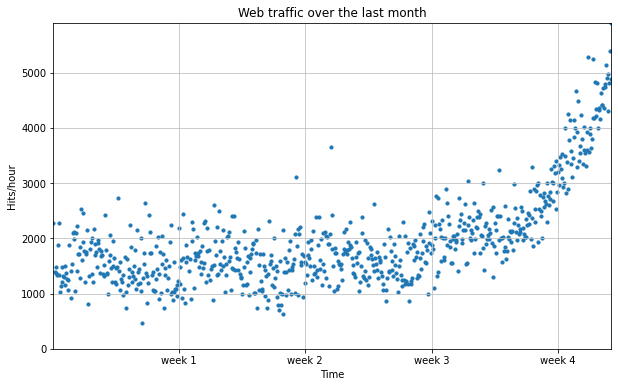

In [6]:
def plot_models(x, y, models, mx=None, ymax=None, xmin=None):
    ''' plot input data '''
    
    colors = ['g', 'k', 'b', 'm', 'r']
    linestyles = ['-', '-.', '--', ':', '-']

    plt.figure(num=None, figsize=(10, 6))
    plt.clf()
    
    plt.scatter(x, y, s=10)
    
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        if mx is None:
            mx = np.linspace(0, x.shape[0], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    plt.grid(True, linestyle='-', color='0.75')
    
plot_models(web_traffic.index, web_traffic.ReqsPerHour, None)

In [7]:
x, y = web_traffic.index, web_traffic.ReqsPerHour

fp1, res1, rank1, sv1, rcond1 = np.polyfit(x, y, 1, full=True)
print("Model parameters of fp1: %s" % fp1)
print("Error of the model of fp1:", res1)
f1 = sp.poly1d(fp1)

Model parameters of fp1: [  2.59619213 989.02487106]
Error of the model of fp1: [3.17389767e+08]


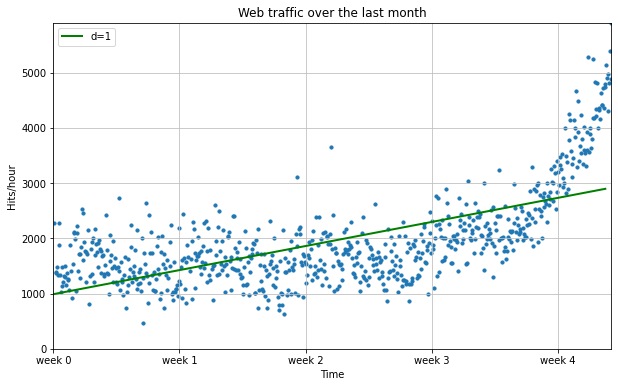

In [8]:
plot_models(x, y, [f1])

Обучим еще несколько моделей с более высокой степенью многочлена:

In [9]:
fp2, res2, rank2, sv2, rcond2 = np.polyfit(x, y, 2, full=True)
print("Model parameters of fp2: %s" % fp2)
print("Error of the model of fp2:", res2)
f2 = sp.poly1d(fp2)
f3 = sp.poly1d(np.polyfit(x, y, 3))
f10 = sp.poly1d(np.polyfit(x, y, 10))
f100 = sp.poly1d(np.polyfit(x, y, 100))

Model parameters of fp2: [ 1.05322215e-02 -5.26545650e+00  1.97476082e+03]
Error of the model of fp2: [1.79983508e+08]


/Users/ise/Documents/Works/yusen/htdocs/budget/intrapy/.venv/lib/python3.7/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/ise/Documents/Works/yusen/htdocs/budget/intrapy/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/ise/Documents/Works/yusen/htdocs/budget/intrapy/.venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Нарисуем эти модели

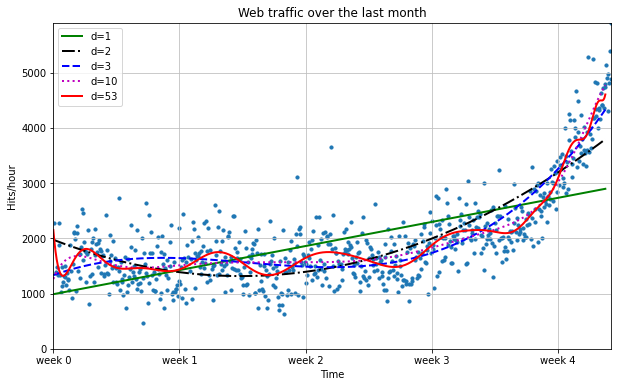

In [10]:
plot_models(x, y, [f1, f2, f3, f10, f100])

Замечаем, что точка перегиба нашего графика находится примерно на середине второй недели. Повторим обучение наших моделей с этим смещением.

In [11]:
# fit and plot a model using the knowledge about inflection point
inflection = int(2.5 * 7 * 24)
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(np.polyfit(xa, ya, 1))
fb = sp.poly1d(np.polyfit(xb, yb, 1))

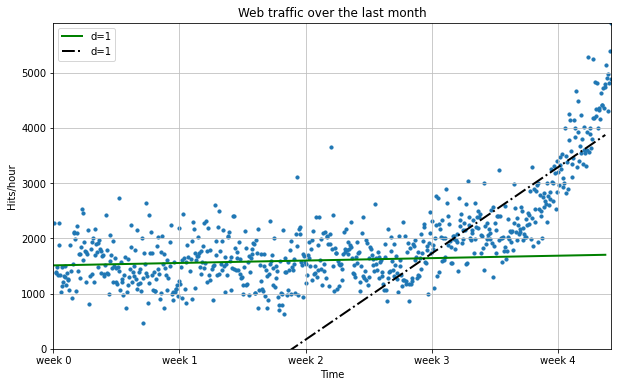

In [12]:
plot_models(x, y, [fa, fb])

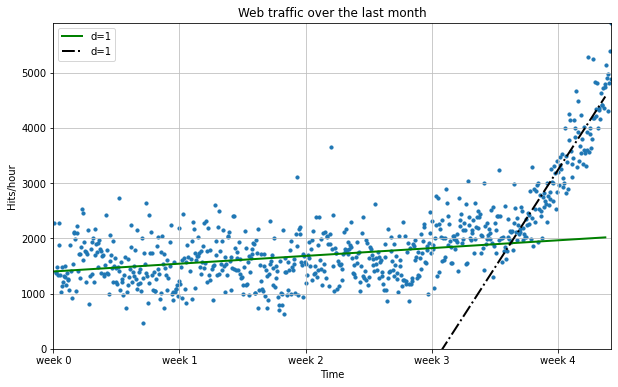

In [13]:
# fit and plot a model using the knowledge about inflection point
inflection = int(3.5 * 7 * 24)
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(np.polyfit(xa, ya, 1))
fb = sp.poly1d(np.polyfit(xb, yb, 1))
plot_models(x, y, [fa, fb])

Нарисуем существующие модели с экстраполяцией в недалекое будущее (до 6-й недели с начала наблюдений)

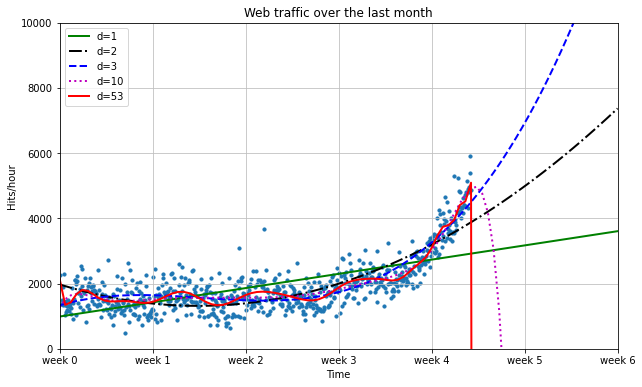

In [14]:
plot_models(
    x, y, [f1, f2, f3, f10, f100],
    mx=np.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

А также создадим несколько моделей, обученных на данных только после второй точки перегиба:

In [15]:
fb1 = fb
fb2 = sp.poly1d(np.polyfit(xb, yb, 2))
fb3 = sp.poly1d(np.polyfit(xb, yb, 3))
fb10 = sp.poly1d(np.polyfit(xb, yb, 10))
fb100 = sp.poly1d(np.polyfit(xb, yb, 100))

/Users/ise/Documents/Works/yusen/htdocs/budget/intrapy/.venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ise/Documents/Works/yusen/htdocs/budget/intrapy/.venv/lib/python3.7/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/ise/Documents/Works/yusen/htdocs/budget/intrapy/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/ise/Documents/Works/yusen/htdocs/budget/intrapy/.venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Нарисуем их:

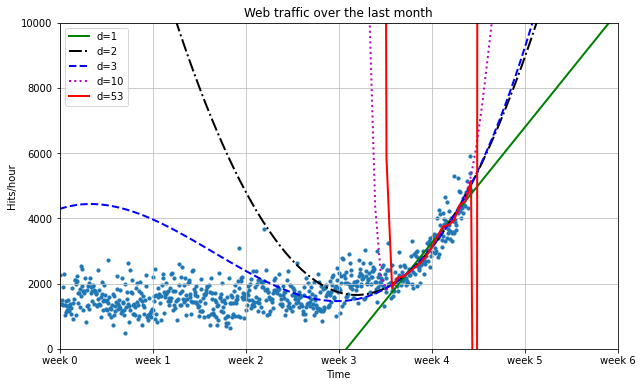

In [16]:
plot_models(
    x, y, [fb1, fb2, fb3, fb10, fb100],
    mx=np.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

#### Оценим точность 

Напишем функцию которая считает среднеквадратичную ошибку для модели и посмотрим, на сколько точны наши первоначальные модели:

In [17]:
def error(f, x, y):
    return np.sum((f(x) - y) ** 2)

print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("Error d={}: {}" .format (f.order, error(f, x, y)))

Errors for the complete data set:
Error d=1: 317389767.339778
Error d=2: 179983507.8781792
Error d=3: 139350144.03172523
Error d=10: 121942326.36358732
Error d=53: 109452415.64865392


...и оценим их же точность, но только после точки перегиба:

In [18]:
print("Errors for only the time after inflection point")
for f in [f1, f2, f3, f10, f100]:
    print("Error d={}: {}" .format(f.order, error(f, xb, yb)))

Errors for only the time after inflection point
Error d=1: 145045835.1344727
Error d=2: 61116348.80962042
Error d=3: 33214248.905597426
Error d=10: 21611594.263691925
Error d=53: 18656112.706603393


...и теперь точность моделей, обученных после точки перегиба:

In [19]:
print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

Errors for only the time after inflection point
Error d=1: 22143941.107618
Error d=2: 19768846.989176
Error d=3: 19766452.361027
Error d=10: 18949296.721348
Error d=53: 18300632.873443


Выберем победительницей модель с полиномом в степени 2. Рассчитаем дату достижения предела в 50000 запросов.

In [20]:
from scipy.optimize import fsolve
reached_max = fsolve(fb2 - 50000, x0=800) / (7 * 24)
print("50,000 hits/hour expected at week %f" % reached_max[0])

50,000 hits/hour expected at week 7.852258


Нарисуем:

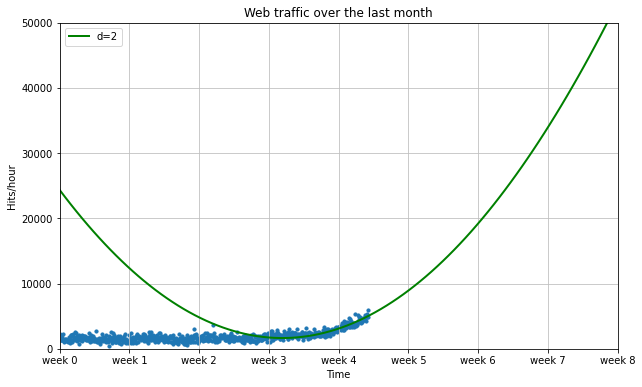

In [21]:
plot_models(
    x, y, [fb2],
    mx=np.linspace(0 * 7 * 24, 8 * 7 * 24, 100),
    ymax=50000, xmin=0 * 7 * 24)

### Пример 2. Кластеризация 

В качестве визуальной оценки данных используется кластеризация.

In [25]:
from sklearn.decomposition import PCA

Метод PCA (метод главных компонент) позволяет уменьшить размерность датасета до 2 (или 3).  Это позволяет визуально оценить "обучаемость" алгоритмов на этих данных. Также метод позволяет выяснить, из чего состоят итоговые компоненты. В основе этого метода лежит сингулярное разложение векторов (SVD). Рассмотрим на примере набора данных "Ирисы":

In [37]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data, iris.target

iris.data.shape

(150, 4)

Meaning of the 2 components:
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


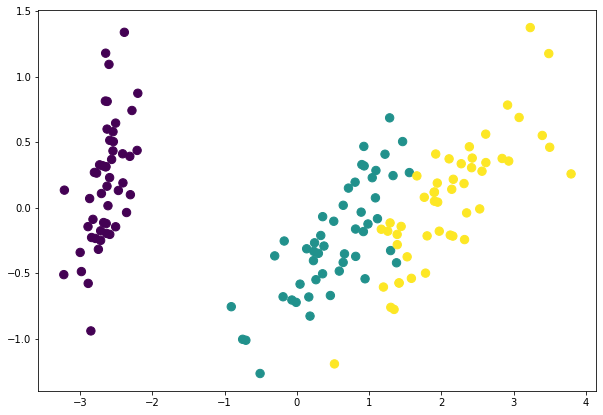

In [26]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))
plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70, cmap='viridis')
plt.show()

Text(0.5, 0, 'z')

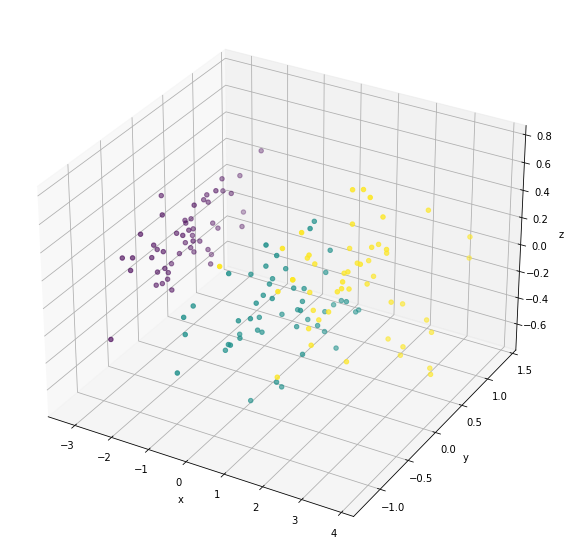

In [39]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter( X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap=plt.cm.get_cmap('viridis'))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Рассмотрим на примере датасета "рукописные цифры". Здесь размерность уменьшена с 64 до 2.

Projecting 64-dimensional data to 2D


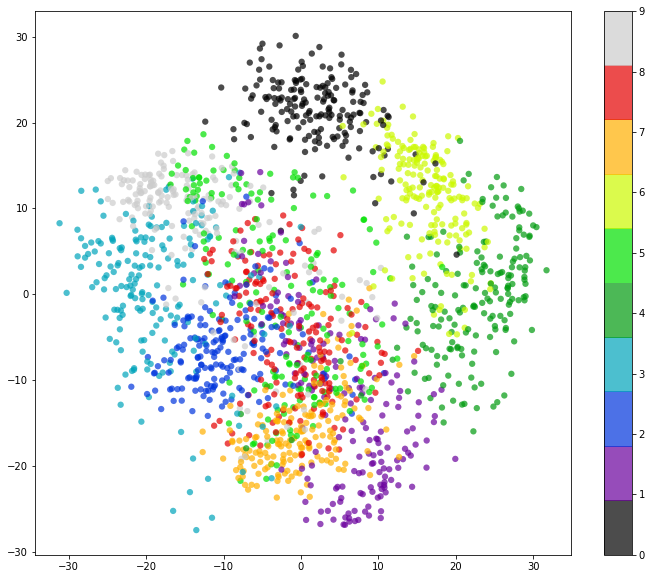

In [27]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

No handles with labels found to put in legend.


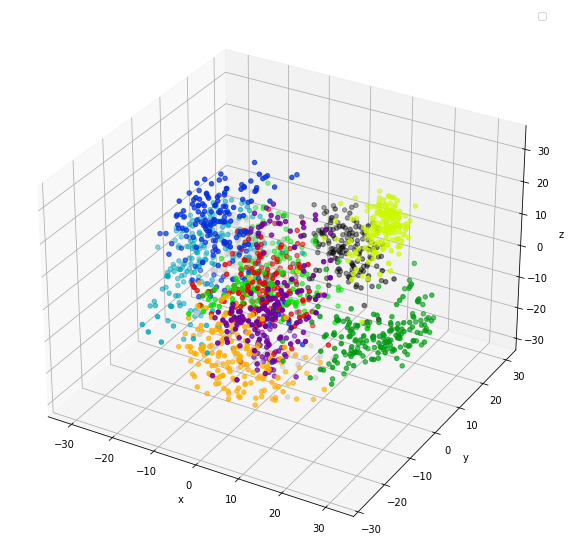

In [36]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter( X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap=plt.cm.get_cmap('nipy_spectral'))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

Пример кластеризации по t-SNE.

<AxesSubplot:>

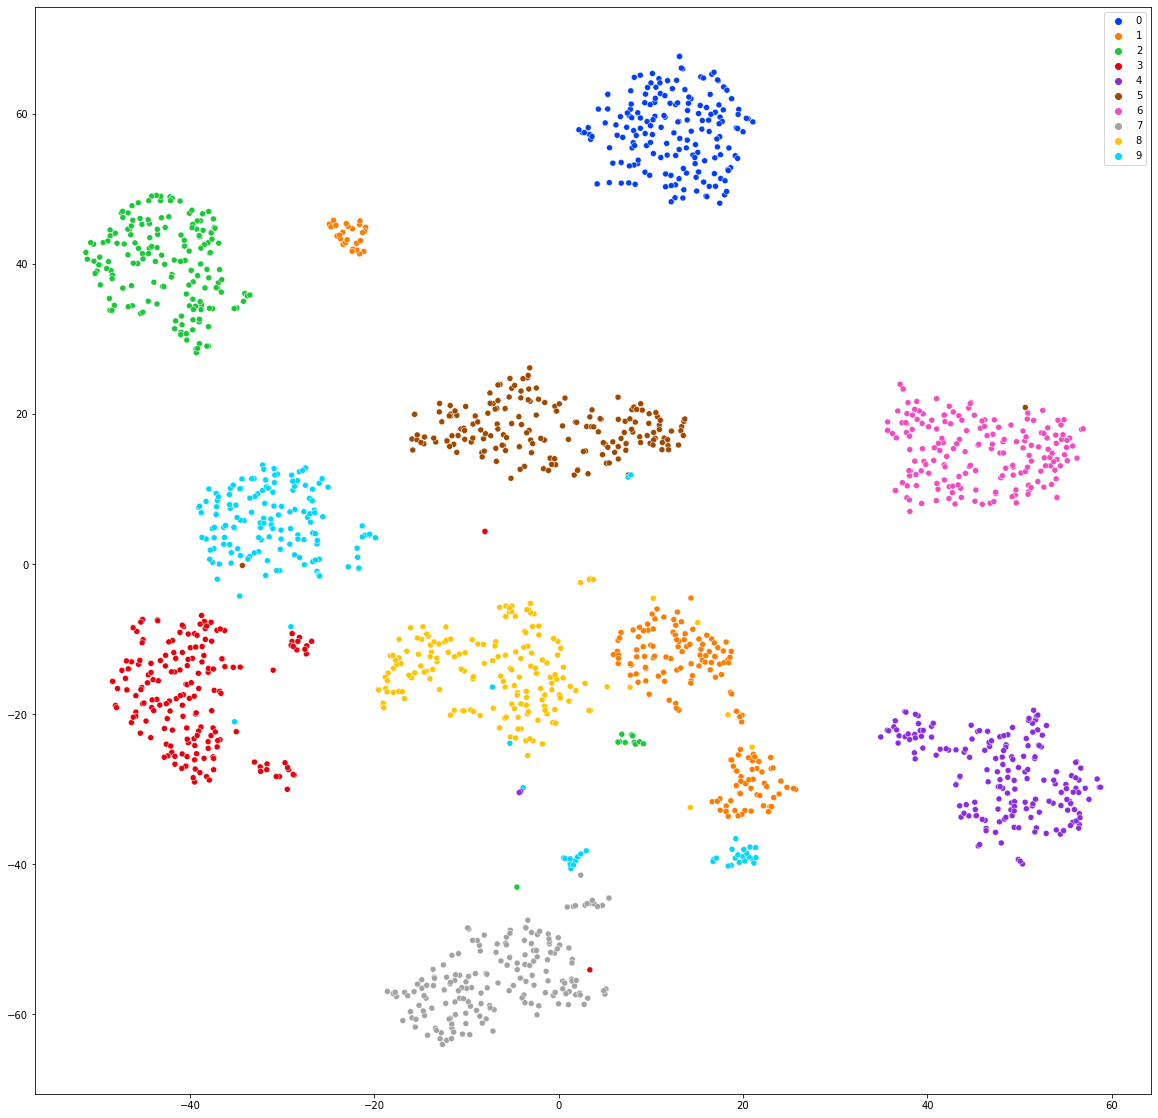

In [28]:
from sklearn.manifold import TSNE

plt.figure(figsize=(20,20))

tsne = TSNE()
X_embedded = tsne.fit_transform(X)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=sns.color_palette("bright", 10))

Text(0.5, 0, 'z')

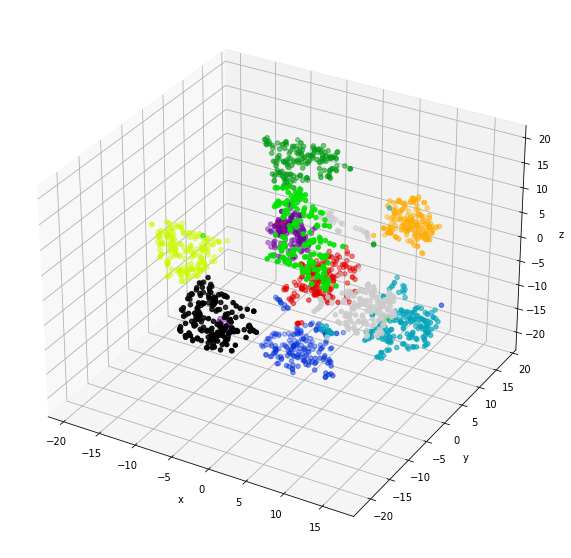

In [33]:
tsne = TSNE(n_components=3)
X_embedded = tsne.fit_transform(X)

ig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter( X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap=plt.cm.get_cmap('nipy_spectral'))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

### Пример 3. Анализ покупательской корзины

Это пример "майнинга данных" - поиска зависимостей и закономерностей в массиве данных. "Анализ покупательской корзины" - довольно часто использующийся метод при построении рекомендательных систем. Базовый алгоритм называется ```Apriori```, он был предложен в 1994 году.

Назначение алгоритма - поиск часто встречающихся подмножеств. Он оперирует следующими понятиями:
 - "суппорт" $Support A$ - вероятность покупки товара A, ее можно вычислить как отношение количества покупок A к общему количеству покупок.
 - "конфидент" $Conf  A{\rightarrow}B$  - вычисляется для пары товаров A и B как отношение случаев совместного приобретения этих товаров к покупкам артикула A
 - "подъем" $Lift  A{\rightarrow}B$  - это отношение вероятности приобретения пары товаров A и B к вероятности приобретения товара A. Или попросту говоря, отношение "конфидента" к "суппорту".
 
Давайте "вытащим" из датасета с данными о покупках в некотором французском супермаркете самые популярные товары и их сочетания с помощью алгоритма ```Apriori```.


Прочитаем датасет и посмотрим на его содержимое:

In [4]:
df_store = pd.read_csv('data/store_data.csv', header=None)
print(df_store.shape)
df_store.head()

(7501, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим на список артикулов и их количество:

In [10]:
df_store.stack().unique()

array(['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes',
       'whole weat flour', 'yams', 'cottage cheese', 'energy drink',
       'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad',
       'mineral water', 'salmon', 'antioxydant juice', 'frozen smoothie',
       'spinach', 'olive oil', 'burgers', 'meatballs', 'eggs', 'chutney',
       'turkey', 'milk', 'energy bar', 'whole wheat rice',
       'whole wheat pasta', 'french fries', 'soup', 'light cream',
       'shallot', 'frozen vegetables', 'spaghetti', 'pet food', 'cookies',
       'cooking oil', 'champagne', 'chocolate', 'chicken', 'oil',
       'fresh tuna', 'tomatoes', 'black tea', 'extra dark chocolate',
       'protein bar', 'red wine', 'pasta', 'pepper', 'shampoo', 'rice',
       'sparkling water', 'ham', 'body spray', 'pancakes',
       'grated cheese', 'white wine', 'toothpaste', 'parmesan cheese',
       'fresh bread', 'ground beef', 'escalope', 'herb & pepper',
       'tomato sauce', 'magazines

На базе исходного dataframe создадим dataframe, в котором признаки приобретения того или иного товара станут булевыми dummy признаками. Для этого мы ему сначала сделаем ```stack()```, получим dummy-признаки, а затем сгруппируем по индексу первого уровня со взятием максимума:

In [37]:
df_dummies = pd.get_dummies(df_store.stack()).groupby(level=0).max()
df_dummies.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Запустим алгоритм Apriori и получим список наиболее часто приобретаемых товаров и их сочетаний:

In [44]:
from mlxtend.frequent_patterns import apriori

df_apriori = apriori(df_dummies, min_support=0.01, use_colnames=True)
df_apriori

,support,itemsets
0,0.020397,(almonds)
1,0.033329,(avocado)
2,0.010799,(barbecue sauce)
3,0.014265,(black tea)
4,0.011465,(body spray)
...,...,...
252,0.011065,"(mineral water, milk, ground beef)"
253,0.017064,"(mineral water, spaghetti, ground beef)"
254,0.015731,"(mineral water, spaghetti, milk)"
255,0.010265,"(mineral water, spaghetti, olive oil)"


Отсортируем список:

In [45]:
df_apriori.sort_values('support', ascending=False)

,support,itemsets
46,0.238368,(mineral water)
19,0.179709,(eggs)
63,0.174110,(spaghetti)
24,0.170911,(french fries)
13,0.163845,(chocolate)
...,...,...
255,0.010265,"(mineral water, spaghetti, olive oil)"
123,0.010132,"(soup, chocolate)"
246,0.010132,"(mineral water, ground beef, eggs)"
249,0.010132,"(mineral water, french fries, spaghetti)"


Теперь получим список самых популярных сочетаний для 2-х и 3-х товаров в корзине:

In [46]:
df_apriori['item_count'] = df_apriori['itemsets'].apply(len)
df_apriori[ df_apriori.item_count >=2 ].sort_values('support', ascending=False)

,support,itemsets,item_count
224,0.059725,"(mineral water, spaghetti)",2
118,0.052660,"(mineral water, chocolate)",2
144,0.050927,"(mineral water, eggs)",2
209,0.047994,"(mineral water, milk)",2
196,0.040928,"(mineral water, ground beef)",2
...,...,...,...
232,0.010265,"(spaghetti, red wine)",2
249,0.010132,"(mineral water, french fries, spaghetti)",3
246,0.010132,"(mineral water, ground beef, eggs)",3
123,0.010132,"(soup, chocolate)",2


### Пример 4. Отбор признаков средствами машинного обучения

Решается задача кредитного скоринга. 

Признаки клиентов банка:
- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный)
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

In [40]:
train_df = pd.read_csv('data/credit_scoring_train.csv', index_col='client_id')
train_df.head()


,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
client_id,,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0


In [41]:
train_df.shape

(75000, 10)

Как обычно, проверим на NaN:

In [42]:
train_df.isnull().sum()

DIR                          0
Age                          0
NumLoans                     0
NumRealEstateLoans           0
NumDependents             1916
Num30-59Delinquencies        0
Num60-89Delinquencies        0
Income                   14847
BalanceToCreditLimit         0
Delinquent90                 0
dtype: int64

Заменим NaN на медианные значения:

In [43]:
train_df['NumDependents'].fillna(train_df['NumDependents'].median(), inplace=True)
train_df['Income'].fillna(train_df['Income'].median(), inplace=True)

Для отбора признаков воспользуемся модулем SelectKBest c определением корелляции по $chi^2$

In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = train_df.iloc[:,:-1]  # определяющие признаки
y = train_df.iloc[:,-1]    # результирующие признаки
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                   Specs          Score
7                 Income  663458.105886
6  Num60-89Delinquencies   52170.942852
5  Num30-59Delinquencies   46880.212062
0                    DIR   35398.322099
1                    Age    4111.293655
8   BalanceToCreditLimit     768.237735
4          NumDependents     261.983308
2               NumLoans     196.315203
3     NumRealEstateLoans       8.895203


Также можно отобрать признаки, используя саму модель - обычно модель возаращает ранжированный по важности список признаков.

[0.16049758 0.16163796 0.10525483 0.04123679 0.04529255 0.07593639
 0.06615408 0.1439236  0.20006622]


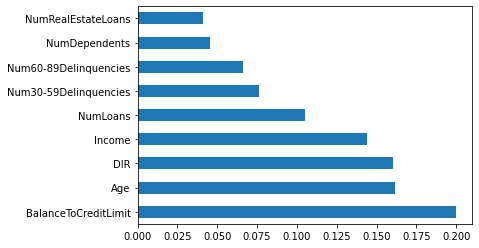

In [46]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Также бывает полезно посмотреть кореляцию признаков с результирующим, построив heatmap.

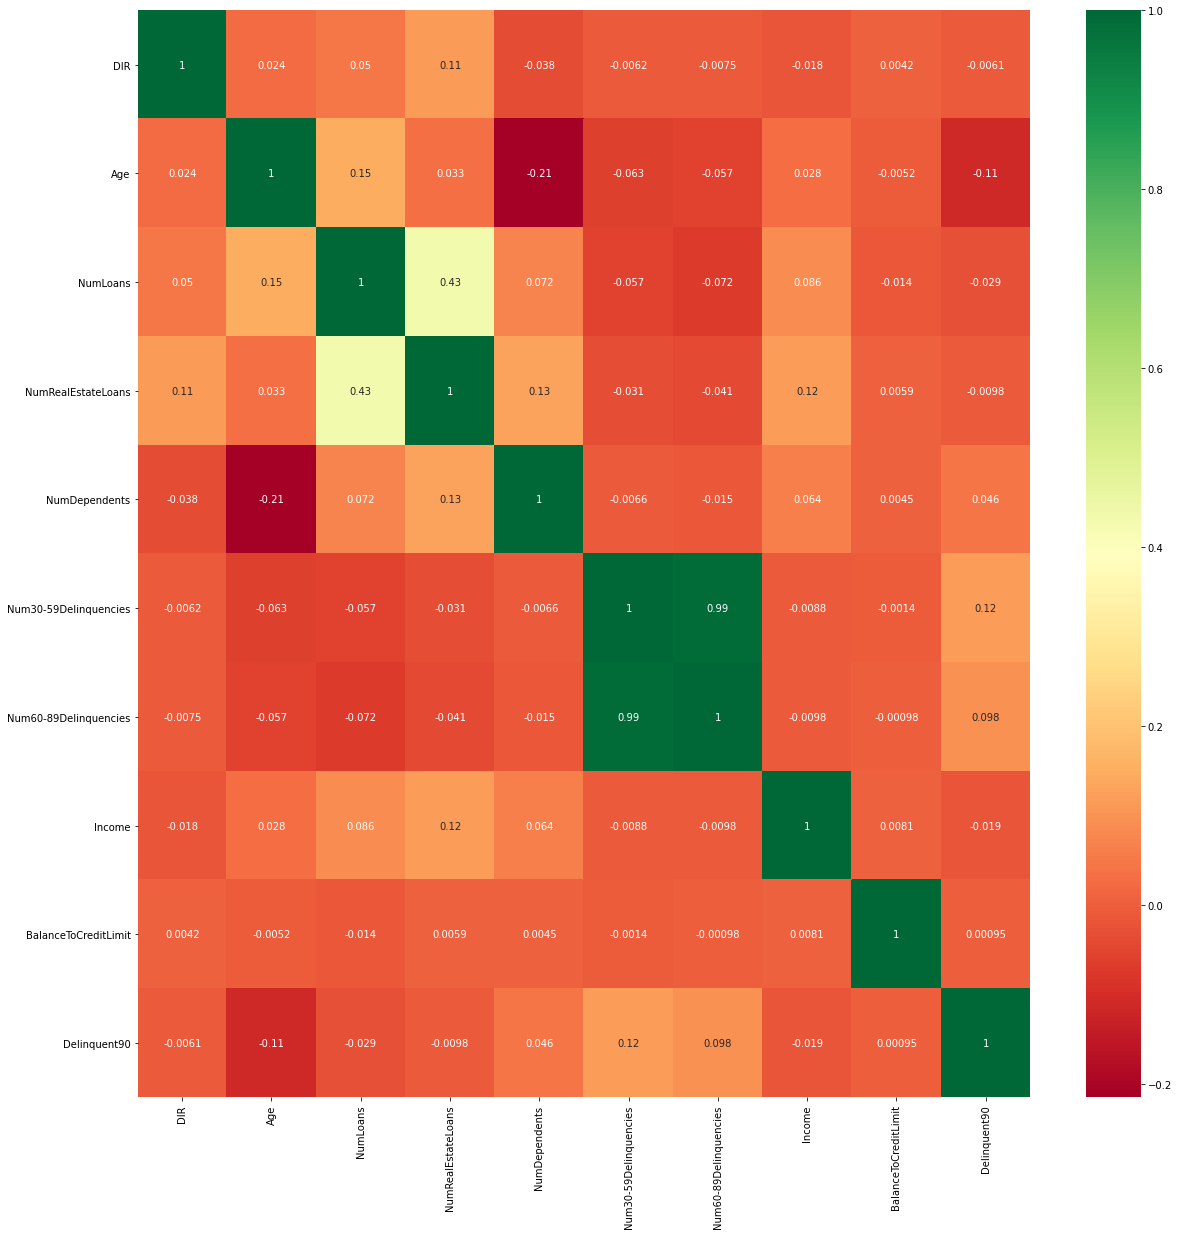

In [47]:
#get correlations of each features in dataset
corrmat = train_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [54]:
X.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
client_id,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679
2,2206.731199,55.5,21,1,0.0,1,0,5424.552473,0.348227
3,886.132793,55.3,3,0,0.0,0,0,5424.552473,0.971930
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350


In [55]:

first_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
first_tree.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [50]:
test_df = pd.read_csv('data/credit_scoring_test.csv', index_col='client_id')

In [51]:
test_df['NumDependents'].fillna(train_df['NumDependents'].median(), inplace=True)
test_df['Income'].fillna(train_df['Income'].median(), inplace=True)
test_df.isnull().sum()

DIR                      0
Age                      0
NumLoans                 0
NumRealEstateLoans       0
NumDependents            0
Num30-59Delinquencies    0
Num60-89Delinquencies    0
Income                   0
BalanceToCreditLimit     0
dtype: int64

In [56]:
first_tree_pred = first_tree.predict(test_df)

In [64]:
np.sqrt(np.sum( (first_tree_pred - y) ** 2))

74.71947537289057

### ПОЛЕЗНОЕ

1. Зарегистрируйтесь на https://keggle.com
2. Читайте специальный раздел на Medium [TowardsDataScience.com](https://towardsdatascience.com)
3. Оттуда - пара статей про векторизацию кода: [1](https://medium.com/@mikeliao/numpy-vectorization-d4adea4fc2a) и [2](https://towardsdatascience.com/python-vectorization-5b882eeef658)
5. Рекомендую книгу о векторизации ["From Python to Numpy"](https://www.labri.fr/perso/nrougier/from-python-to-numpy/)
4. Еще можно бесплатно пройти курсы Стэнфорского Университета: "Машинное обучение", [CS229](http://cs229.stanford.edu/), "Глубокое обучение", [CS231n](http://cs231n.stanford.edu/).


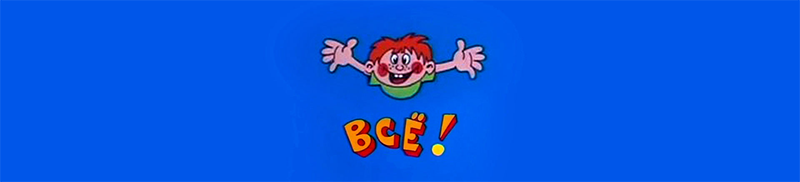